In [466]:
import numpy as np
%matplotlib notebook
%matplotlib notebook
import matplotlib.pyplot as plt
np.random.seed(1)
import tqdm

Relu neurons

In [467]:
d = 2 # dimension of space
M = 2 # number of neurons for generation

In [468]:
def relu(x):
    if x >= 0:
        return x
    return 0.

In [469]:
def drelu(x):
    if x >= 0:
        return 1.
    return 0.

In [470]:
class Neuron:
    def __init__(self):
        a = np.random.normal()
        w = np.random.normal(size = d)
        b = np.random.normal()
        norm = np.linalg.norm(np.concatenate([np.array([a, b]), w]), 2)
        self.a = a / norm
        self.w = w / norm
        self.b = b / norm
    def set_weights(self, a, w, b):
        self.a = a
        self.w = w.copy()
        self.b = b
    def forward(self, x):
        return self.a * relu(self.w.dot(x) + self.b)

In [504]:
class Network:
    def __init__(self, width):
        self.width = width
        self.neurons = [Neuron() for i in range(width)]
    def output(self, x):
        return np.mean([n.forward(x) for n in self.neurons])
    def loss(self, x, y):
        return .5*(self.output(x) - y)**2
    def grad(self, x, y):
        d = (self.output(x) - y)
        s = np.array([relu(n.w.dot(x) + n.b) for n in self.neurons])
        ds = np.array([drelu(n.w.dot(x) + n.b) for n in self.neurons])
        ga = 1./self.width * d * s
        gb = 1./self.width * d * np.array([self.neurons[i].a*ds[i] for i in range(self.width)])
        gw = np.array([gb[i] * x for i in range(self.width)]) # shape m * d
        return ga, gw, gb
    def step(self, x, y, tau):
        ga, gw, gb = self.grad(x, y)
        for i in range(self.width):
            nr = self.neurons[i]
            a_new = nr.a - tau * ga[i]
            w_new = nr.w - tau * gw[i]
            b_new = nr.b - tau * gb[i]
            nr.set_weights(a_new, w_new, b_new)
    def batch_step(self, X, Y, tau):
        ba = X.shape[0]
        Ga, Gw, Gb = np.zeros((ba, self.width)), np.zeros((ba, self.width, d)), np.zeros((ba, self.width))
        for i in range(ba):
            Ga[i], Gw[i], Gb[i] = self.grad(X[i], Y[i])
        ga, gw, gb = Ga.mean(axis = 0), Gw.mean(axis = 0), Gb.mean(axis = 0)
        for i in range(self.width):
            nr = self.neurons[i]
            a_new = nr.a - tau * ga[i]
            w_new = nr.w - tau * gw[i]
            b_new = nr.b - tau * gb[i]
            nr.set_weights(a_new, w_new, b_new)
    def sgd_train(self, X, Y, tau, epochs, batch, disp = True):
        for e in range(epochs):
            pm = np.random.permutation(X.shape[0])
            X = np.array([X[pm[i]] for i in range(X.shape[0])])
            Y = np.array([Y[pm[i]] for i in range(Y.shape[0])])
            if batch > 1:
                nbatch = X.shape[0]//batch
                subX = np.split(X, nbatch)
                subY = np.split(Y, nbatch)
                for s in range(len(subX)):
                    self.batch_step(subX[s], subY[s], tau)
            else:
                for i in range(X.shape[0]):
                    self.step(X[i], Y[i], tau)
            loss = self.test(X, Y)
            if disp:
                print('epoch '+str(e)+' : '+str(loss))
        return loss
    def test(self, X_t, Y_t):
        ts = X_t.shape[0]
        return np.mean([self.loss(X_t[i], Y_t[i]) for i in range(ts)])
    def gen_sample(self, s = 1):
        if s==1:
            X = np.random.normal(size = d)
            Y = self.output(X)
            return X, Y
        else:
            X = np.random.normal(size = (s, d))
            Y = np.zeros(s)
            for i in range(s):
                Y[i] = self.output(X[i])
            return X, Y
    def give_weights(self):
        la, lw, lb = np.zeros(self.width), np.zeros((self.width, d)), np.zeros(self.width)
        for i in range(self.width):
            nr = self.neurons[i]
            la[i] = nr.a
            lw[i] = nr.w
            lb[i] = nr.b
        return la, lw, lb
        
    def display_weights(self, fig, ax, true_w = None, color='b'):
        assert d==2, 'must be in dimension 2'
        ax.cla()
        ax.set_xlim((-1, 1))
        ax.set_ylim((-1, 1))
        la, lw, _ = self.give_weights()
        x, y = np.zeros(self.width), np.zeros(self.width)
        for k in range(self.width):
            x[k] = lw[k, 0] * la[k]
            y[k] = lw[k, 1] * la[k] 
        pos = ax.scatter(x, y, s = 10., color=color)
        #trpos = ax.scatter(xp, yp, s = 10, color='r')
        #trneg = ax.scatter(xn, yn, s = 10, color='b')
                
        if true_w is not None:
            tla, tlw, tlb = true_w
            tx, ty = np.zeros(tla.shape[0]), np.zeros(tla.shape[0])
            for k in range(tla.shape[0]):
                tx[k] = tlw[k, 0] * tla[k]
                ty[k] = tlw[k, 1] * tla[k]
                if tx[k]>= 0:
                    u = np.linspace(0., 1.5, 10)
                else:
                    u = np.linspace(-1.5, 0., 10)
                v = ty[k]/tx[k] * u
                ax.plot(u, v, color = 'g')
        fig.canvas.draw()
        

<IPython.core.display.Javascript object>


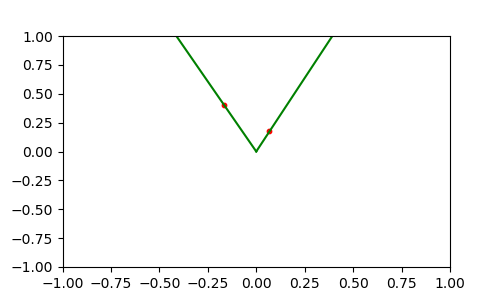

In [506]:
fig, ax = plt.subplots(figsize=(5, 3))
gen_net = Network(M)
true_w = gen_net.give_weights()
gen_net.display_weights(fig, ax, color='r', true_w = true_w)

Initialize new network with parameters normal.

Train it using SGD

In [509]:
net = Network(10)

<IPython.core.display.Javascript object>


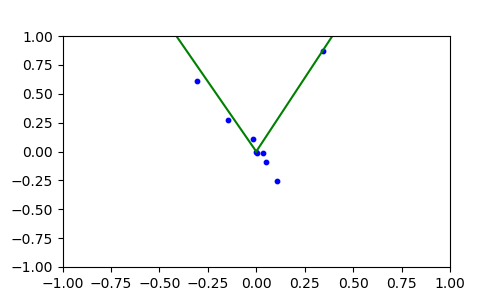

In [510]:
fig, ax = plt.subplots(figsize=(5, 3))
net.display_weights(fig, ax, true_w = true_w)

X, Y = gen_net.gen_sample(1000)
#print('init', net.test(X, Y))
for i in range(1000):
    X, Y = gen_net.gen_sample(100)
    net.sgd_train(X, Y, tau = 1., batch = 1, epochs = 1, disp = False)
    net.display_weights(fig, ax, true_w = true_w)

Trying to reproduce the visual experiment

ReLU activation function: we show for each particle the trajectory $|w(t)| \theta(t) \in R^2$
 (here = a * w). The initialization is uniformly random on a sphere around 0 (this satisfies asymptotically the separation condition). This case has a homogeneous structure and is treated separately in the paper.